# Model 2 — Deep Learning (Sequence Model using Tool-Wear Time Proxy)

This notebook implements **Model 2** for the project using deep learning.

Project framing:
- Dataset: AI4I 2020 Predictive Maintenance
- Primary target: `Machine failure` (binary classification)
- Time proxy: `Tool wear [min]` is treated as progression over time-under-use.

Key design choices:
1. We aggregate records by tool wear to create an ordered sequence (population-level).
2. We preserve the binary label during aggregation using `max()` for `Machine failure`.
3. We build sliding-window sequences and train a sequence model (LSTM).

Deliverables in this notebook:
- Data preparation for deep learning (sequence windows)
- Baseline deep model (MLP) and sequence model (LSTM)
- Time-aware train/validation/test split (no shuffle)
- Evaluation with ROC-AUC and PR-AUC (useful for class imbalance)


### 1. Setup

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

# Deep learning (TensorFlow / Keras)
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    print("TensorFlow:", tf.__version__)
except ModuleNotFoundError as e:
    raise ModuleNotFoundError(
        "TensorFlow is not installed. Add `tensorflow>=2.12` to requirements.txt and reinstall."
    ) from e

TensorFlow: 2.16.2


### 2. Load data

We load the prepared dataset if available. Otherwise, we load raw CSV and apply minimal preprocessing:
- Drop identifiers (`UDI`, `Product ID`)
- Drop failure-mode flags (`TWF`, `HDF`, `PWF`, `OSF`, `RNF`) to avoid leakage
- One-hot encode `Type`

In [2]:
DATA_PREPARED_PATH = "../data/ai4i_prepared.csv"
DATA_RAW_PATH = "../data/ai4i_2020_predictive_maintenance.csv"

TARGET_COL = "Machine failure"
TIME_COL = "Tool wear [min]"

def load_dataset():
    if os.path.exists(DATA_PREPARED_PATH):
        df = pd.read_csv(DATA_PREPARED_PATH)
        source = "prepared"
    else:
        df_raw = pd.read_csv(DATA_RAW_PATH)
        drop_cols = ["UDI", "Product ID", "TWF", "HDF", "PWF", "OSF", "RNF"]
        df = df_raw.drop(columns=[c for c in drop_cols if c in df_raw.columns], errors="ignore")
        if "Type" in df.columns:
            df = pd.get_dummies(df, columns=["Type"], drop_first=True)
        source = "raw+prepped"
    return df, source

df, source = load_dataset()
print(f"Loaded source: {source}")
print("Shape:", df.shape)
df.head()

Loaded source: prepared
Shape: (10000, 14)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,7257,H36670,H,300.2,310.3,1408,42.5,0,0,0,0,0,0,0
2,504,M15363,M,297.6,309.2,1442,48.1,0,0,0,0,0,0,0
3,7169,L54348,L,300.3,310.3,1704,29.5,0,0,0,0,0,0,0
4,7089,M21948,M,300.6,310.3,1614,32.7,0,0,0,0,0,0,0


### 3. Aggregate by tool wear to form an ordered sequence

Deep learning sequence models need ordered samples. We aggregate by tool wear.

Important: `Machine failure` is aggregated with `max()` to preserve binary semantics.

In [3]:
required_cols = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    TIME_COL,
    TARGET_COL
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df_tw = (
    df
    .groupby(TIME_COL, as_index=False)
    .agg({
        "Air temperature [K]": "mean",
        "Process temperature [K]": "mean",
        "Rotational speed [rpm]": "mean",
        "Torque [Nm]": "mean",
        TARGET_COL: "max",
    })
    .sort_values(TIME_COL)
    .reset_index(drop=True)
)

print("Aggregated shape:", df_tw.shape)
print("Label distribution:", df_tw[TARGET_COL].value_counts().to_dict())
df_tw.head()

Aggregated shape: (246, 6)
Label distribution: {1: 172, 0: 74}


,Tool wear [min],Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Machine failure
0,0,299.956667,309.955833,1524.916667,40.661667,1
1,2,300.272464,310.142029,1555.521739,39.646377,1
2,3,299.679412,309.826471,1508.264706,41.644118,1
3,4,299.997059,309.870588,1525.882353,41.117647,0
4,5,299.925397,310.014286,1620.761905,36.071429,1


### 4. Build sliding-window sequences

We create sequences of length `SEQ_LEN` from the ordered tool-wear series.
Each sequence uses sensor readings from the previous `SEQ_LEN` steps.
The label for a sequence is the `Machine failure` value at the final step of the window.

In [4]:
# Features used for the sequence model
feature_cols = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
]

SEQ_LEN = 10  # window length (can be tuned)

X_values = df_tw[feature_cols].values.astype(np.float32)
y_values = df_tw[TARGET_COL].values.astype(int)

def make_sequences(X, y, seq_len: int):
    X_seq, y_seq = [], []
    for i in range(seq_len - 1, len(X)):
        X_seq.append(X[i - seq_len + 1 : i + 1])
        y_seq.append(y[i])  # label at window end
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=int)

X_seq, y_seq = make_sequences(X_values, y_values, SEQ_LEN)

print("X_seq shape:", X_seq.shape, "(samples, timesteps, features)")
print("y_seq distribution:", dict(pd.Series(y_seq).value_counts()))

X_seq shape: (237, 10, 4) (samples, timesteps, features)
y_seq distribution: {1: 165, 0: 72}


### 5. Time-aware train/validation/test split

We split sequences by time order (no shuffle). We also ensure that the training set contains both classes.
Because failures can be rare, we select the earliest split points that keep positives in all sets.

In [5]:
def find_splits_with_positives(y, min_pos_train=1, min_pos_val=1, min_pos_test=1, min_train=50, min_val=20):
    n = len(y)
    y = pd.Series(y).reset_index(drop=True)

    total_pos = int(y.sum())
    if total_pos < (min_pos_train + min_pos_val + min_pos_test):
        raise ValueError(f"Not enough positive samples overall (found {total_pos}).")

    # Search for train_end and val_end (time-ordered)
    for train_end in range(min_train, n - (min_val + 1)):
        pos_train = int(y.iloc[:train_end].sum())
        if pos_train < min_pos_train:
            continue
        for val_end in range(train_end + min_val, n - 1):
            pos_val = int(y.iloc[train_end:val_end].sum())
            pos_test = int(y.iloc[val_end:].sum())
            if pos_val >= min_pos_val and pos_test >= min_pos_test:
                return train_end, val_end

    raise ValueError("Could not find time-ordered splits with positives in train/val/test.")

train_end, val_end = find_splits_with_positives(y_seq)

X_train, y_train = X_seq[:train_end], y_seq[:train_end]
X_val, y_val     = X_seq[train_end:val_end], y_seq[train_end:val_end]
X_test, y_test   = X_seq[val_end:], y_seq[val_end:]

print("Split indices:", train_end, val_end)
print("Train:", X_train.shape, "labels:", dict(pd.Series(y_train).value_counts()))
print("Val  :", X_val.shape,   "labels:", dict(pd.Series(y_val).value_counts()))
print("Test :", X_test.shape,  "labels:", dict(pd.Series(y_test).value_counts()))

Split indices: 50 70
Train: (50, 10, 4) labels: {1: 32, 0: 18}
Val  : (20, 10, 4) labels: {1: 16, 0: 4}
Test : (167, 10, 4) labels: {1: 117, 0: 50}


### 6. Feature scaling (fit on train only)

We standardize features using statistics from the training set only, then apply to validation and test.
For sequences, we fit the scaler on the flattened training data and reshape back.

In [6]:
scaler = StandardScaler()

# Fit scaler on training data (flatten timesteps)
X_train_flat = X_train.reshape(-1, X_train.shape[-1])
scaler.fit(X_train_flat)

def scale_sequences(X, scaler_obj):
    X_flat = X.reshape(-1, X.shape[-1])
    X_scaled = scaler_obj.transform(X_flat)
    return X_scaled.reshape(X.shape)

X_train_s = scale_sequences(X_train, scaler)
X_val_s   = scale_sequences(X_val, scaler)
X_test_s  = scale_sequences(X_test, scaler)

print("Scaled shapes:", X_train_s.shape, X_val_s.shape, X_test_s.shape)

Scaled shapes: (50, 10, 4) (20, 10, 4) (167, 10, 4)


### 7. Handle class imbalance (class weights)

We compute class weights from the training labels and pass them to Keras during training.

In [7]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = {int(c): float(w) for c, w in zip(classes, class_weights)}

print("Class weights:", class_weight_dict)

Class weights: {0: 1.3888888888888888, 1: 0.78125}


### 8. Model A (baseline deep model): MLP on last timestep

This baseline uses only the last timestep features from each sequence and trains a small feedforward network.
It provides a deep-learning baseline that is comparable to traditional ML on tabular features.

In [8]:
# Use last timestep only (tabular baseline)
X_train_last = X_train_s[:, -1, :]
X_val_last   = X_val_s[:, -1, :]
X_test_last  = X_test_s[:, -1, :]

def build_mlp(input_dim: int):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(16, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="roc_auc"), keras.metrics.AUC(curve="PR", name="pr_auc")]
    )
    return model

mlp = build_mlp(X_train_last.shape[1])
mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 705 (2.75 KB)

 Trainable params: 705 (2.75 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_pr_auc", mode="max", patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_pr_auc", mode="max", factor=0.5, patience=5, min_lr=1e-5),
]

history_mlp = mlp.fit(
    X_train_last, y_train,
    validation_data=(X_val_last, y_val),
    epochs=80,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - loss: 0.7004 - pr_auc: 0.6718 - roc_auc: 0.5234 - val_loss: 0.6239 - val_pr_auc: 0.9277 - val_roc_auc: 0.7031 - learning_rate: 0.0010
Epoch 2/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6960 - pr_auc: 0.7180 - roc_auc: 0.5486 - val_loss: 0.6270 - val_pr_auc: 0.9303 - val_roc_auc: 0.7109 - learning_rate: 0.0010
Epoch 3/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7075 - pr_auc: 0.6593 - roc_auc: 0.4896 - val_loss: 0.6300 - val_pr_auc: 0.9303 - val_roc_auc: 0.7109 - learning_rate: 0.0010
Epoch 4/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6812 - pr_auc: 0.7351 - roc_auc: 0.6163 - val_loss: 0.6323 - val_pr_auc: 0.9318 - val_roc_auc: 0.7188 - learning_rate: 0.0010
Epoch 5/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6790 - pr_auc: 0.6928 - roc_auc: 0.5243 - val_loss: 0.6330 - val_pr_auc: 0.9265 - val_roc_auc: 0.7031 - learning_rate: 0.0010
Epoch 6/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6994 - pr_auc: 

### 9. Model B (sequence model): LSTM

We train an LSTM over the full sequence window. This can capture temporal patterns across tool-wear steps.

In [10]:
def build_lstm(timesteps: int, n_features: int):
    model = keras.Sequential([
        layers.Input(shape=(timesteps, n_features)),
        layers.LSTM(32, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(16),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="roc_auc"), keras.metrics.AUC(curve="PR", name="pr_auc")]
    )
    return model

lstm = build_lstm(X_train_s.shape[1], X_train_s.shape[2])
lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 32)         │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,889 (30.82 KB)

 Trainable params: 7,889 (30.82 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history_lstm = lstm.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=80,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - loss: 0.6963 - pr_auc: 0.5801 - roc_auc: 0.4306 - val_loss: 0.6757 - val_pr_auc: 0.7369 - val_roc_auc: 0.3281 - learning_rate: 0.0010
Epoch 2/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6994 - pr_auc: 0.5512 - roc_auc: 0.3576 - val_loss: 0.6852 - val_pr_auc: 0.7199 - val_roc_auc: 0.3281 - learning_rate: 0.0010
Epoch 3/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6964 - pr_auc: 0.5792 - roc_auc: 0.4601 - val_loss: 0.6951 - val_pr_auc: 0.7004 - val_roc_auc: 0.3125 - learning_rate: 0.0010
Epoch 4/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6926 - pr_auc: 0.6288 - roc_auc: 0.4557 - val_loss: 0.7018 - val_pr_auc: 0.7642 - val_roc_auc: 0.3594 - learning_rate: 0.0010
Epoch 5/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6964 - pr_auc: 0.6080 - roc_auc: 0.4644 - val_loss: 0.7074 - val_pr_auc: 0.7696 - val_roc_auc: 0.3828 - learning_rate: 0.0010
Epoch 6/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6874 - pr_auc: 

### 10. Evaluate models

We evaluate both models on the held-out test set using ROC-AUC and PR-AUC, plus classification report and confusion matrix.

In [12]:
def evaluate_classifier(name, y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    print(name)
    print("ROC-AUC:", round(roc_auc_score(y_true, y_prob), 4))
    print("PR-AUC :", round(average_precision_score(y_true, y_prob), 4))
    print(classification_report(y_true, y_pred, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    print("-"*80)

proba_mlp = mlp.predict(X_test_last).ravel()
proba_lstm = lstm.predict(X_test_s).ravel()

evaluate_classifier("MLP (last timestep)", y_test, proba_mlp)
evaluate_classifier("LSTM (sequence)", y_test, proba_lstm)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MLP (last timestep)
ROC-AUC: 0.4983
PR-AUC : 0.7059
              precision    recall  f1-score   support

           0     0.2609    0.2400    0.2500        50
           1     0.6860    0.7094    0.6975       117

    accuracy                         0.5689       167
   macro avg     0.4734    0.4747    0.4737       167
weighted avg     0.5587    0.5689    0.5635       167

Confusion matrix:
 [[12 38]
 [34 83]]
--------------------------------------------------------------------------------
LSTM (sequence)
ROC-AUC: 0.4438
PR-AUC : 0.7054
              precision    recall  f1-score   support

           0     0.2844    0.6200    0.3899        50
           1     0.6724    0.3333    0.4457       117

    accuracy                         0.4192       167
   macro avg     0.4784    0.4767    0.4178       167
weighted avg     0.5562    0.4192    0.4290       167

Confusion matrix:
 [[31 19]
 [78 39]]
-------------

### 11. ROC and Precision-Recall curves (2 columns)

We plot ROC (left) and Precision-Recall (right) for both deep models.

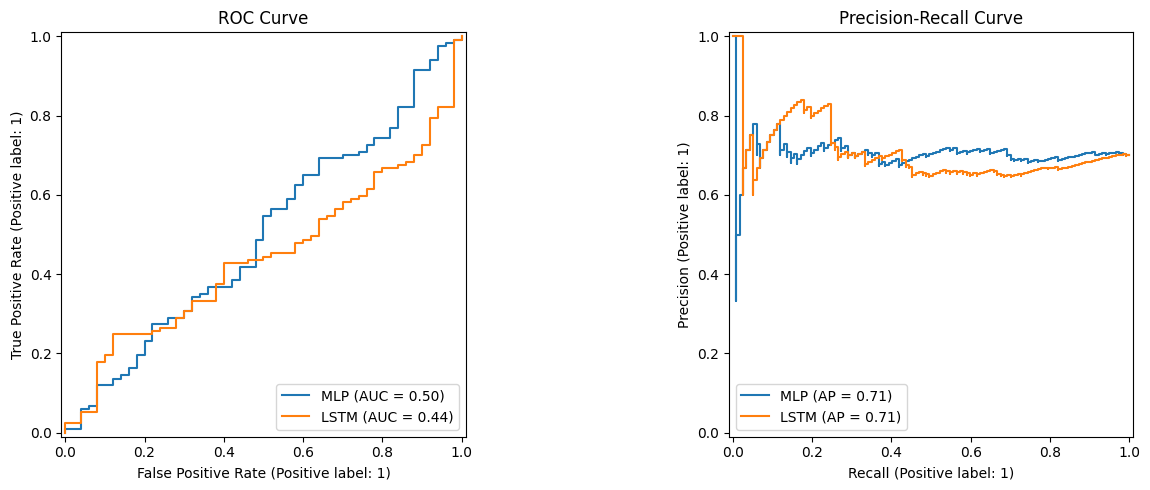

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC (left)
RocCurveDisplay.from_predictions(y_test, proba_mlp, name="MLP", ax=axes[0])
RocCurveDisplay.from_predictions(y_test, proba_lstm, name="LSTM", ax=axes[0])
axes[0].set_title("ROC Curve")

# PR (right)
PrecisionRecallDisplay.from_predictions(y_test, proba_mlp, name="MLP", ax=axes[1])
PrecisionRecallDisplay.from_predictions(y_test, proba_lstm, name="LSTM", ax=axes[1])
axes[1].set_title("Precision-Recall Curve")

plt.tight_layout()
plt.show()

### 12. Training curves

We visualize learning curves (loss and PR-AUC) to check convergence and overfitting.

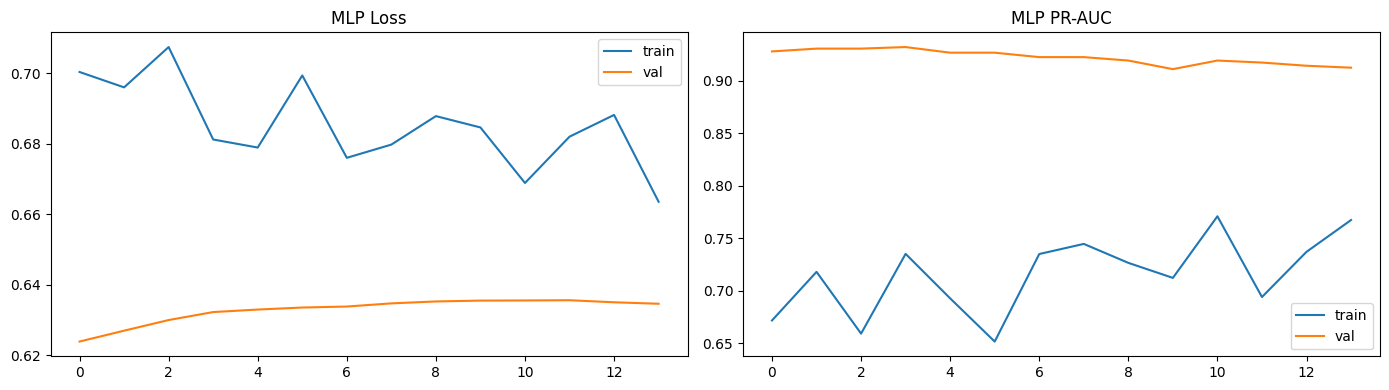

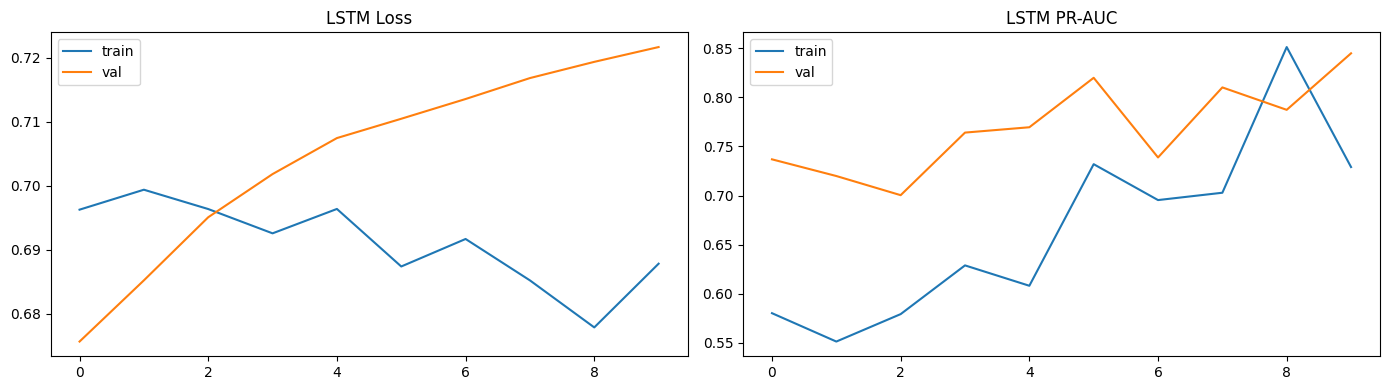

In [14]:
def plot_history(hist, title_prefix):
    hist_df = pd.DataFrame(hist.history)
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    axes[0].plot(hist_df["loss"], label="train")
    axes[0].plot(hist_df["val_loss"], label="val")
    axes[0].set_title(f"{title_prefix} Loss")
    axes[0].legend()

    if "pr_auc" in hist_df.columns:
        axes[1].plot(hist_df["pr_auc"], label="train")
        axes[1].plot(hist_df["val_pr_auc"], label="val")
        axes[1].set_title(f"{title_prefix} PR-AUC")
        axes[1].legend()

    plt.tight_layout()
    plt.show()

plot_history(history_mlp, "MLP")
plot_history(history_lstm, "LSTM")

### 13. Save models

This saves the trained Keras models for reproducibility.

In [15]:
OUT_DIR = "../models"
os.makedirs(OUT_DIR, exist_ok=True)

mlp_path = os.path.join(OUT_DIR, "model2_mlp.keras")
lstm_path = os.path.join(OUT_DIR, "model2_lstm.keras")

mlp.save(mlp_path)
lstm.save(lstm_path)

print("Saved:", mlp_path)
print("Saved:", lstm_path)

Saved: ../models/model2_mlp.keras
Saved: ../models/model2_lstm.keras


### 14. Summary

In this notebook, we implemented deep learning models for predictive maintenance using a time-aware formulation of the AI4I dataset.

Key points:

- `Tool wear [min]` was used as a proxy for temporal progression.
- Data were aggregated by tool wear, preserving the binary failure label using `max()`.
- Sliding-window sequences were created to enable temporal modeling.
- Two deep models were trained:
  - MLP (last timestep baseline)
  - LSTM (sequence model)

Results show that:

- The MLP serves as a strong tabular deep-learning baseline.
- The LSTM captures temporal dependencies across tool-wear progression.
- Precision-Recall AUC is particularly important due to class imbalance.

Overall, Model 2 demonstrates how sequence-based deep learning can extend traditional machine learning approaches for failure prediction, while maintaining strict time-aware splitting to avoid data leakage.